1. Setup Libraries

In [1]:
#import mario gym open AI environment and nes_py library
%pip install gym_super_mario_bros==7.3.0 nes_py

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import the game
import gym_super_mario_bros
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [3]:
# Setup game
env = gym_super_mario_bros.make('SuperMarioBros-v0')    #, apply_api_compatibility=True, render_mode='human'
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [4]:
done = True
# Loop through each frame in the game
for step in range(100000): 
    # Start the game to begin with 
    if done: 
        # Start the game
        env.reset()
    # For random actions
    state, reward, done, info = env.step(env.action_space.sample())
    # Show the game on the screen we will use render
    env.render()
# Close the game
env.close()

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


KeyboardInterrupt: 

: 

2. Preprocess Environment

In [4]:
# Install pytorch
# %pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
# %pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113
%pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Install stable baselines for RL stuff
%pip install stable-baselines3[extra]

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import Matplotlib to show graph
from matplotlib import pyplot as plt

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# 1. Create the base environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')
# 2. Simplify the controls 
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# 3. Grayscale
env = GrayScaleObservation(env, keep_dim=True)
# 4. Wrap inside the Dummy Environment
env = DummyVecEnv([lambda: env])
# 5. Stack the frames
env = VecFrameStack(env, 4, channels_order='last')

In [6]:
#store starting environment in state variable
state = env.reset()

In [12]:
#setting up the setup
state, reward, done, info = env.step([5])

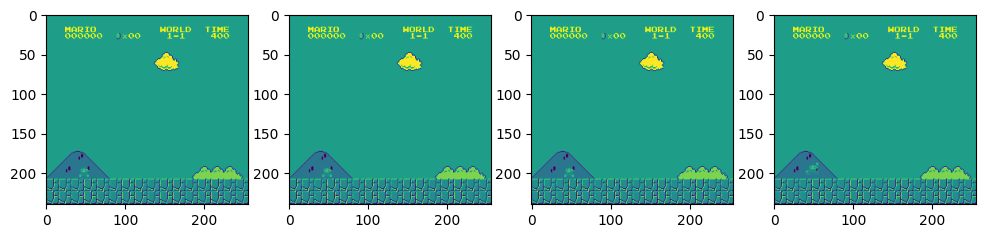

In [13]:
#ploting the graph of mario frame
plt.figure(figsize=(12,16)) #set size
for idx in range(state.shape[3]):   #different state shape (3) times loop will be run
    plt.subplot(1,4,idx+1)  #subploting the graph for index+1
    plt.imshow(state[0][:,:,idx])   #showing the graph for state
plt.show()  #show all graph merge

3. Train the RL Model

In [14]:
# Import os for file path management
import os 
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [15]:
#class for the training data and set trained model directory
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):   #self is same as this keyword in java
        super(TrainAndLoggingCallback, self).__init__(verbose)  #constructer
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls)) #savepath+best model number will be at place
            self.model.save(model_path)
        return True

In [21]:
#All path directories
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [22]:
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [23]:
# AI model started with learning rate and steps
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, n_steps=512)

Using cpu device
Wrapping the env in a VecTransposeImage.


In [24]:
# Training the AI model, AI model starts to learn
model.learn(total_timesteps=1000000, callback=callback)

Logging to ./logs/PPO_2
----------------------------
| time/              |     |
|    fps             | 72  |
|    iterations      | 1   |
|    time_elapsed    | 7   |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 14            |
|    iterations           | 2             |
|    time_elapsed         | 71            |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 2.3321016e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | -0.00149      |
|    learning_rate        | 1e-06         |
|    loss                 | 277           |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000102     |
|    value_loss           | 712           |
-------------------------

KeyboardInterrupt: 

In [21]:
#saving the model
model.save('thisisatestmodel')

4. Test it Out

In [25]:
# Loading the model
model = PPO.load('./train/best_model_100000')

In [26]:
#set new starting game state in state variable
state = env.reset()

: 

In [19]:
# Starting the game 
state = env.reset()
# Loop for all the game
while True:
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


KeyboardInterrupt: 